# Iteration 2

## 1 Aim:
The aim of the second iteration is to consider admitting patients from elective surgery route based on the model we have created in the first iteration.

## 2 Prompt engineering & LLM results:

In the paper published by Griffiths et al. (2010), the simulation model of CCU admits patients from two different routes: `"unplanned admission"` and `"planned admission"`. We have already built a simulation model for the former route. 

In the latter route, patients from elective surgery route can only enter the system when there are unoccupied beds, or they have to cancel the surgery if no bed is available at present. After their admission and treatment, they will leave the system immediately. 

The distributions of inter-arrival time (IAT) and length of stay (LOS) among the planned admitted patients are relatively complex and time-dependent. As shown in Figure 1, in a weekly period (168 hours), a large proportion of IAT was between 0 to 4 hours, and there were smaller peaks repeating every 24 hours afterwards. This cyclical trend was attributed to the clinical practice, where elective surgery were conducted at certain sessions spaced at 24 h intervals. Hence, for the arrival times, authors stated that they fitted a normal distribution with a mean value of 17.91 and a standard deviation of 3.16 if they consider a daily cycle beginning and ending at 07:00. Besides, the majority of elective surgery was conducted on Monday (17%) or between Tuesday and Friday (around 83%), with very few surgeries spreading over the weekend. Thus, for simplification, we aimed to create an arrival generator function simulating elective surgery patients with a truncated normal distribution, assuming that all surgeries are performed in weekdays. In the paper, a total of 1182 elective surgery admissions was recorded over a 3-year period, so we would use that number to calculate daily sample size.

As for the LOS distribution, it exhibited a similar pattern to the IAT distribution, although authors utilised empirical data to sample for LOS.  In our study, LOS distribution was fitted with a log-normal distribution using the mean and standard deviation values obtained from the paper.


&nbsp;

<div style="text-align: center;"><em>Table 1. Simulation parameters for elective surgery patients. </em></div>

| Activity     	  | Source        	  | Distribution 	| Mean (hours) 	| Standard Dev (hours) 	|
| --------------- | :---------------- | :--------------	| :------------	| :-------------------- |
| Daily arrivals  |  Elective         | Normal       	| 17.91         |  3.16                 |
| LOS             |  Elective         | Lognormal    	| 57.34         |  99.78                |

&nbsp;

<div style="text-align: center;"><em>Figure 1. IAT distribution for elective surgery patients (Griffiths et al. (2010)).</em></div>
<img src="fig1.JPG" width="400" style="display: block; margin: 0 auto">





Therefore, based on the description, we intended to develop a promt for generating elective surgery arrivals first:

### 2.1 Generate arrival generator function

> ### Main command
Code a arrival generator function for elective surgery patients in python 3.10 and simpy 4. All time units are in hours.
> ### Steps
> 1. Create a function to sample daily arrival times. The arrival times distribution is a a normal distribution with a mean value of 17.91 and a standard deviation of 3.16, truncated at 0 and 24 as the lower and higher boundary (hours). Sample size and random seed are included as parameters. Return a list of arrival times.
> 2. Create a weekly patient arrivals generator function. The method only simulates arrivals for weekdays (i.e., day of week 0 to 4 representing Monday to Friday) and skips weekends (i.e. day of week 5 or 6) by using a if-else check. The method include a daily loop, generating a list of arrival times for that day by calling the sampling function in step 1. Each arrival time in the list is the simulation time unit when a patient should arrive. Arrival times in the list are within each 24-hour period and need to be converted in the simulation process. Random seed can be calculated based on number of week and day of week for generating new lists everytime to ensure variety.
> 3. Run the simulation. Print out patient arrival times (indicating day of week, number of weeks).
> 4. Parameters: 
> - daily sample size = 1182 / 12 / 30 / 3, take the interger value
> - RUN_LENGTH = 24 * 7 * num_weeks (set num_weeks as 8 first)

The LLM results are listed as follows:

In [1]:
'''
To implement the arrival generator function for elective 
surgery patients according to the specified steps, 
we'll first define the function to sample daily arrival 
times using a truncated normal distribution. 
Then, we'll create the weekly patient arrivals generator 
function that simulates arrivals only on weekdays. 
Finally, we'll set up and run the simulation, 
printing out patient arrival times with the day of 
the week and number of weeks information.

Let's start coding these steps in Python using SimPy:
'''
import numpy as np
from scipy.stats import truncnorm
import simpy
import math

def sample_daily_arrival_times(mean, std, lower_bound, upper_bound, sample_size, random_seed):
    """
    Sample daily arrival times from a truncated normal distribution.
    """
    np.random.seed(random_seed)
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    daily_arrival_times = truncnorm.rvs(a, b, loc=mean, scale=std, size=sample_size)
    daily_arrival_times.sort()
    return daily_arrival_times

def weekly_patient_arrivals_generator(env, num_weeks, daily_sample_size, mean, std, lower_bound, upper_bound):
    """
    Generate patient arrivals for weekdays.
    """
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for week in range(num_weeks):
        for day_of_week in range(7):  # Loop through each day of the week
            if 0 <= day_of_week <= 4:  # Check for weekdays
                # Adjust random seed based on week and day for variety
                random_seed = week * 7 + day_of_week
                daily_arrival_times = sample_daily_arrival_times(mean, std, lower_bound, upper_bound, 
                                                                 daily_sample_size, random_seed)
                
                for arrival_time in daily_arrival_times:
                    yield env.timeout(arrival_time)
                    print(f"Patient arrived at hour {env.now:.2f} on {days_of_week[day_of_week]}, Week {week + 1}")
            else:
                # Skip weekends
                continue

# Parameters
daily_sample_size = int(1182 / 12 / 30 / 3)  # Taking the integer value
mean = 17.91
std = 3.16
lower_bound = 0
upper_bound = 24
num_weeks = 8  # Set number of weeks
RUN_LENGTH = 24 * 7 * num_weeks

# Setup and run the simulation
env = simpy.Environment()
env.process(weekly_patient_arrivals_generator(env, num_weeks, daily_sample_size, mean, std, lower_bound, upper_bound))
env.run(until=RUN_LENGTH)

Patient arrived at hour 18.18 on Monday, Week 1
Patient arrived at hour 35.34 on Tuesday, Week 1
Patient arrived at hour 52.64 on Wednesday, Week 1
Patient arrived at hour 70.84 on Thursday, Week 1
Patient arrived at hour 93.69 on Friday, Week 1
Patient arrived at hour 107.03 on Monday, Week 2
Patient arrived at hour 128.21 on Tuesday, Week 2
Patient arrived at hour 138.78 on Wednesday, Week 2
Patient arrived at hour 158.83 on Thursday, Week 2
Patient arrived at hour 173.79 on Friday, Week 2
Patient arrived at hour 191.70 on Monday, Week 3
Patient arrived at hour 212.58 on Tuesday, Week 3
Patient arrived at hour 228.02 on Wednesday, Week 3
Patient arrived at hour 244.15 on Thursday, Week 3
Patient arrived at hour 263.13 on Friday, Week 3
Patient arrived at hour 275.76 on Monday, Week 4
Patient arrived at hour 291.04 on Tuesday, Week 4
Patient arrived at hour 308.98 on Wednesday, Week 4
Patient arrived at hour 331.65 on Thursday, Week 4
Patient arrived at hour 352.79 on Friday, Week 4
P

As we can see, the elective surgery arrivals did not follow the predefined arrival times due to the bug within the `yield env.timeout(arrival_time)`. In that case, patients wait for the period in the generated arrival list, rather than admit at that scheduled timepoint. Hence, we tried to fix the bug manually.

In [2]:
import numpy as np
from scipy.stats import truncnorm
import simpy
import math

def sample_daily_arrival_times(mean, std, lower_bound, upper_bound, sample_size, random_seed):
    """
    Sample daily arrival times from a truncated normal distribution.
    """
    np.random.seed(random_seed)
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    daily_arrival_times = truncnorm.rvs(a, b, loc=mean, scale=std, size=sample_size)
    daily_arrival_times.sort()
    return daily_arrival_times

                
def weekly_patient_arrivals_generator(env, num_weeks, daily_sample_size, mean, std, lower_bound, upper_bound):
    """
    Generate patient arrivals for weekdays.
    """
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for week in range(num_weeks):
        for day_of_week in range(7):  # Loop through each day of the week
            current_day = week * 7 + day_of_week  # Calculate the absolute day 
            
            if 0 <= day_of_week <= 4:  # Check for weekdays
                # Adjust random seed based on week and day for variety
                random_seed = current_day
                daily_arrival_times = sample_daily_arrival_times(mean, std, lower_bound, upper_bound, 
                                                                 daily_sample_size, random_seed)
                
                last_arrival_time = current_day * 24  # Convert current day to hours
                
                for arrival_time in daily_arrival_times:
                    actual_arrival_time = last_arrival_time + arrival_time
                    yield env.timeout(actual_arrival_time - env.now)
                    print(f"Patient arrived at hour {env.now:.2f} on {days[day_of_week]}, Week {week + 1}")
            else:
                # Skip weekends
                print(f"Skip arrivals for {days[day_of_week]}, Week {week + 1}")
                continue

                
# Parameters
daily_sample_size = int(1182 / 12 / 30 / 3)  # Taking the integer value
mean = 17.91
std = 3.16
lower_bound = 0
upper_bound = 24
num_weeks = 8  # Set number of weeks
RUN_LENGTH = 24 * 7 * num_weeks

# Setup and run the simulation
env = simpy.Environment()
env.process(weekly_patient_arrivals_generator(env, num_weeks, daily_sample_size, mean, std, lower_bound, upper_bound))
env.run(until=RUN_LENGTH)

Patient arrived at hour 18.18 on Monday, Week 1
Patient arrived at hour 41.16 on Tuesday, Week 1
Patient arrived at hour 65.31 on Wednesday, Week 1
Patient arrived at hour 90.20 on Thursday, Week 1
Patient arrived at hour 118.85 on Friday, Week 1
Skip arrivals for Saturday, Week 1
Skip arrivals for Sunday, Week 1
Patient arrived at hour 181.34 on Monday, Week 2
Patient arrived at hour 213.18 on Tuesday, Week 2
Patient arrived at hour 226.57 on Wednesday, Week 2
Patient arrived at hour 260.05 on Thursday, Week 2
Patient arrived at hour 278.96 on Friday, Week 2
Skip arrivals for Saturday, Week 2
Skip arrivals for Sunday, Week 2
Patient arrived at hour 353.91 on Monday, Week 3
Patient arrived at hour 380.87 on Tuesday, Week 3
Patient arrived at hour 399.44 on Wednesday, Week 3
Patient arrived at hour 424.13 on Thursday, Week 3
Patient arrived at hour 450.98 on Friday, Week 3
Skip arrivals for Saturday, Week 3
Skip arrivals for Sunday, Week 3
Patient arrived at hour 516.63 on Monday, Week 

Next, we modified the weekly arrivals generator function to validate the arrival patterns by plotting the histogram.

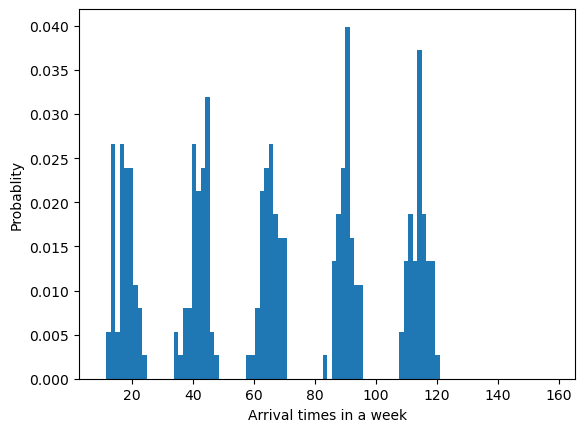

In [3]:
import matplotlib.pyplot as plt
        
def weekly_patient_arrivals_generator(num_weeks, daily_sample_size, mean, std, lower_bound, upper_bound):
    """
    Generate patient arrivals for weekdays.
    """
    actual_arrival_list = [] # add a list to arrival weekly arrival times
    
    for week in range(num_weeks):
        for day_of_week in range(7):  # Loop through each day of the week
            
            if 0 <= day_of_week <= 4:  # Check for weekdays
                # Adjust random seed based on week and day for variety
                random_seed = week * 7 + day_of_week
                daily_arrival_times = sample_daily_arrival_times(mean, std, lower_bound, upper_bound, 
                                                                 daily_sample_size, random_seed)                
                for arrival_time in daily_arrival_times:                    
                    # append the weekly arrival times
                    weely_arrival_time = day_of_week * 24 + arrival_time
                    actual_arrival_list.append(weely_arrival_time)
                
    return actual_arrival_list
                
# Parameters
daily_sample_size = int(1182 / 12 / 30 / 3)  # Taking the integer value
mean = 17.91
std = 3.16
lower_bound = 0
upper_bound = 24
num_weeks = 51  # Set one year

# Obtain the weekly arrival times list
actual_arrival_list = weekly_patient_arrivals_generator(num_weeks, daily_sample_size, 
                                              mean, std, lower_bound, upper_bound)


# Plot the ditribution of weekly arrival times
plt.hist(np.array(actual_arrival_list), bins = 100, density=True, range= [10, 158])
plt.xlabel('Arrival times in a week')
plt.ylabel('Probablity')
plt.show()

As shown in the graph, the arrival times in a weekly cycle basically matched the description in the paper, when we set the time 0 as 07:00 on Monday. 


### 2.2 Construct simulation model
Next, we implemented the arrival generator function of elective surgery patients in the current simulation model, thus we included the code of the simulation model in the first iteration in the new prompt. The prompt is described as follows:

> ### Main command
> We have created a discrete-event simulation model of a critical care unit (CCU) in python 3.10 and simpy 4. Now modify the original code and add a new admitting rule for elective surgery patients (named as es).
> Please code the full model specified. Do not return a simplified version. Show all code.
> ### 1 Rule logic:
> * All time units in the model are in hours.
> * Patients arriving from elective surgery route will check if there are unoccupied beds first. If so, they will enter the unit and stay. Otherwise, they have to cancel the surgery and are not allowed to wait for a bed. After their admission, they will stay in CCU for a certain period, which is sampling from length of stay (LOS) distribution, and then they will leave the system immediately.
> * Create a `class ElectivePatient` based on the `class Patient`. Modify the service method to meet the new logic. Within the `__init__` function, create a list to track the patients who cancel the surgery. The LOS distribution for elective surgery patients is fitted using a Lognormal distribution (Mean: 57.34, std: 99.78).
> * Elective surgery patient should have a unique arrival generator function within the `class CCU`. For the arrival generator function, use the sample_daily_arrival_times and weekly_patient_arrivals_generator function generated in the previous prompt.
>
> ### 2 Original code of simulation model:
> ```python
> import simpy
import numpy as np
import itertools
from scipy.stats import lognorm
> # Custom classes for distributions
class Exponential:
    def __init__(self, mean, random_seed=None):
        self.mean = mean
        self.rng = np.random.default_rng(seed=random_seed)    
    def sample(self):
        return self.rng.exponential(self.mean)
> class Lognormal:
    def __init__(self, mean, std, random_seed=None):
        self.mean = mean
        self.std = std
        self.rng = np.random.default_rng(seed=random_seed)
        self.sigma = np.sqrt(np.log(1 + (std/mean)**2))
        self.scale = np.exp(np.log(mean) - 0.5*self.sigma**2)    
    def sample(self):
        return self.rng.lognormal(np.log(self.scale), self.sigma)
> # Patient class
class Patient:
    def __init__(self, env, patient_id, source, los_dist):
        self.env = env
        self.patient_id = patient_id
        self.source = source
        self.los_dist = los_dist
    def service(self, ccu):
        arrive_time = self.env.now
        print(f"Patient {self.patient_id} from {self.source} arrived at {arrive_time:.2f}")
        with ccu.request() as request:
            yield request
            wait_time = self.env.now - arrive_time
            los = self.los_dist.sample()
            print(f"Patient {self.patient_id} from {self.source} waited for {wait_time:.2f} hours, LOS: {los:.2f}")
            yield self.env.timeout(los)
            print(f"Patient {self.patient_id} from {self.source} left at {self.env.now:.2f}")
> # CCU class
class CCU:
    def __init__(self, env, capacity):
        self.env = env
        self.resource = simpy.Resource(env, capacity=capacity)
    def ae_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "ae", los_dist)
            self.env.process(patient.service(self.resource))
    # Additional generators for other patient sources can be similarly defined
    def ward_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "ward", los_dist)
            self.env.process(patient.service(self.resource))            
    def emer_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "emer", los_dist)
            self.env.process(patient.service(self.resource))            
    def oth_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "oth", los_dist)
            self.env.process(patient.service(self.resource))            
    def xray_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "xray", los_dist)
            self.env.process(patient.service(self.resource))
> # Simulation parameters
RUN_LENGTH = 12 * 30 * 24  # 12 months
N_BEDS = 24
patient_id_generator = itertools.count()
> # Initialize simulation environment
env = simpy.Environment()
ccu = CCU(env, N_BEDS)
> # Patient arrival source distributions
IAT_DISTRIBUTIONS = {
    "ae": Exponential(22.72),
    "ward": Exponential(26.0),
    "emer": Exponential(37.0),
    "oth": Exponential(47.2),
    "xray": Exponential(575.0)
}
> # Patient LOS distributions
LOS_DISTRIBUTIONS = {
    "ae": Lognormal(128.79, 267.51),
    "ward": Lognormal(177.89, 276.54),
    "emer": Lognormal(140.15, 218.02),
    "oth": Lognormal(212.86, 457.67),
    "xray": Lognormal(87.53, 108.15)
}
> # Starting the patient sources for "ae"
env.process(ccu.ae_arrivals_generator(IAT_DISTRIBUTIONS["ae"], LOS_DISTRIBUTIONS["ae"]))
env.process(ccu.ward_arrivals_generator(IAT_DISTRIBUTIONS["ward"], LOS_DISTRIBUTIONS["ward"]))
env.process(ccu.emer_arrivals_generator(IAT_DISTRIBUTIONS["emer"], LOS_DISTRIBUTIONS["emer"]))
env.process(ccu.oth_arrivals_generator(IAT_DISTRIBUTIONS["oth"], LOS_DISTRIBUTIONS["oth"]))
env.process(ccu.xray_arrivals_generator(IAT_DISTRIBUTIONS["xray"], LOS_DISTRIBUTIONS["xray"]))
> # Run the simulation
env.run(until=RUN_LENGTH)
> ```

Since the generated code is a modification based on the original code in the prompt and can not be executed alone, we will combine the answers together and fix the bug to successfully run the simulation. The raw LLM results are listed as follows:

```python
'''
Step 1: Creating the ElectivePatient Class
First, let's create the ElectivePatient subclass, 
which includes the new LOS distribution and the 
logic for elective surgery patients:
'''


class ElectivePatient(Patient):
    cancelled_surgeries = []  # Track patients who cancel surgery

    def __init__(self, env, patient_id, source, los_dist):
        super().__init__(env, patient_id, source, los_dist)
    
    def service(self, ccu):
        arrive_time = self.env.now
        print(f"Elective surgery patient {self.patient_id} arrived at {arrive_time:.2f}")

        if ccu.resource.count < ccu.resource.capacity:
            with ccu.request() as request:
                yield request
                los = self.los_dist.sample()
                print(f"Elective surgery patient {self.patient_id} admitted with LOS: {los:.2f}")
                yield self.env.timeout(los)
                print(f"Elective surgery patient {self.patient_id} left at {self.env.now:.2f}")
        else:
            ElectivePatient.cancelled_surgeries.append(self.patient_id)
            print(f"Elective surgery patient {self.patient_id} surgery cancelled at {arrive_time:.2f}")


'''
Step 2: Integrating the Elective Surgery Arrival Generator
Now, let's integrate the elective surgery patient arrival 
generator within the CCU class. This function will use 
the sample_daily_arrival_times and 
weekly_patient_arrivals_generator functions created previously:
'''


class CCU:
    # Existing __init__ and other generators remain unchanged

    def es_arrivals_generator(self, num_weeks, daily_sample_size, mean, std, lower_bound, upper_bound):
        days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        
        def sample_daily_arrival_times(mean, std, lower_bound, upper_bound, sample_size, random_seed):
            np.random.seed(random_seed)
            a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
            daily_arrival_times = truncnorm.rvs(a, b, loc=mean, scale=std, size=sample_size)
            daily_arrival_times.sort()
            return daily_arrival_times

        for week in range(num_weeks):
            for day_of_week in range(5):  # Monday to Friday
                random_seed = week * 7 + day_of_week
                daily_arrival_times = sample_daily_arrival_times(mean, std, lower_bound, upper_bound, daily_sample_size, random_seed)
                
                for arrival_time in daily_arrival_times:
                    yield self.env.timeout(arrival_time)
                    patient_id = next(patient_id_generator)
                    los_dist = Lognormal(57.34, 99.78, random_seed)  # LOS distribution for elective surgery
                    patient = ElectivePatient(self.env, patient_id, "es", los_dist)
                    self.env.process(patient.service(self.resource))
                    print(f"Elective surgery patient {patient_id} scheduled to arrive at {self.env.now:.2f} on {days_of_week[day_of_week]}, Week {week + 1}")



'''
Step 3: Adjusting Simulation Parameters for Elective Surgery Patients
Finally, adjust the simulation parameters to 
include the elective surgery patient arrivals:
'''


# Elective surgery patient parameters
daily_sample_size = int(1182 / 12 / 30)  # Daily sample size calculation
mean_es = 57.34  # Mean for LOS distribution
std_es = 99.78  # Std for LOS distribution
num_weeks_es = 8  # Number of weeks for simulation

# Adding elective surgery patient arrival generator to the simulation
env.process(ccu.es_arrivals_generator(num_weeks_es, daily_sample_size, mean_es, std_es, 0, 24))

# Run the simulation
env.run(until=RUN_LENGTH)


```

The integrated simulation model is displayed below:

In [4]:
import simpy
import numpy as np
import itertools
from scipy.stats import lognorm, truncnorm
import math


# Custom classes for distributions
class Exponential:
    def __init__(self, mean, random_seed=None):
        self.mean = mean
        self.rng = np.random.default_rng(seed=random_seed)

    def sample(self):
        return self.rng.exponential(self.mean)

class Lognormal:
    def __init__(self, mean, std, random_seed=None):
        self.mean = mean
        self.std = std
        self.rng = np.random.default_rng(seed=random_seed)
        self.sigma = np.sqrt(np.log(1 + (std/mean)**2))
        self.scale = np.exp(np.log(mean) - 0.5*self.sigma**2)

    def sample(self):
        return self.rng.lognormal(np.log(self.scale), self.sigma)
    

# Sample function for elective surgery
def sample_daily_arrival_times(mean, std, lower_bound, upper_bound, sample_size, random_seed):
    """
    Sample daily arrival times from a truncated normal distribution.
    """
    np.random.seed(random_seed)
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    daily_arrival_times = truncnorm.rvs(a, b, loc=mean, scale=std, size=sample_size)
    daily_arrival_times.sort()
    return daily_arrival_times

    
# Patient class
class Patient:
    def __init__(self, env, patient_id, source, los_dist):
        self.env = env
        self.patient_id = patient_id
        self.source = source
        self.los_dist = los_dist

    def service(self, ccu):
        arrive_time = self.env.now
        print(f"Patient {self.patient_id} from {self.source} arrived at {arrive_time:.2f}")

        with ccu.request() as request:
            yield request
            wait_time = self.env.now - arrive_time
            los = self.los_dist.sample()
            print(f"Patient {self.patient_id} from {self.source} waited for {wait_time:.2f} hours, LOS: {los:.2f}")
            yield self.env.timeout(los)
            print(f"Patient {self.patient_id} from {self.source} left at {self.env.now:.2f}")
            
            
# ElectivePatient class            
class ElectivePatient(Patient):
    def __init__(self, env, patient_id, source, los_dist):
        super().__init__(env, patient_id, source, los_dist)
        self.cancelled_surgeries = []  # Track patients who cancel surgery
    
    def service(self, ccu):
        arrive_time = self.env.now
        print(f"Patient {self.patient_id} from {self.source} arrived at {arrive_time:.2f}")

        if ccu.count < ccu.capacity:
            with ccu.request() as request:
                yield request
                los = self.los_dist.sample()
                print(f"Patient {self.patient_id} from {self.source} admitted with LOS: {los:.2f}")
                yield self.env.timeout(los)
                print(f"Patient {self.patient_id} from {self.source} left at {self.env.now:.2f}")
        else:
            self.cancelled_surgeries.append(self.patient_id)
            print(f"Patient {self.patient_id} from {self.source} cancelled at {arrive_time:.2f}")
            

# CCU class
class CCU:
    def __init__(self, env, capacity):
        self.env = env
        self.resource = simpy.Resource(env, capacity=capacity)

    def ae_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "ae", los_dist)
            self.env.process(patient.service(self.resource))

    def ward_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "ward", los_dist)
            self.env.process(patient.service(self.resource))

    def emer_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "emer", los_dist)
            self.env.process(patient.service(self.resource))

    def oth_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "oth", los_dist)
            self.env.process(patient.service(self.resource))

    def xray_arrivals_generator(self, iat_dist, los_dist):
        while True:
            yield self.env.timeout(iat_dist.sample())
            patient_id = next(patient_id_generator)
            patient = Patient(self.env, patient_id, "xray", los_dist)
            self.env.process(patient.service(self.resource))
            
    def es_arrivals_generator(self, num_weeks, mean, std, lower_bound, upper_bound, daily_sample_size, los_dist):
        while True:
            for week in range(num_weeks):
                for day_of_week in range(7):  # Loop through each day of the week
                    current_day = week * 7 + day_of_week  # Calculate the absolute day 

                    if 0 <= day_of_week <= 4:  # Check for weekdays
                        # Adjust random seed based on week and day for variety
                        random_seed = week * 7 + day_of_week
                        daily_arrival_times = sample_daily_arrival_times(mean, std, lower_bound, upper_bound, 
                                                                         daily_sample_size, random_seed)

                        last_arrival_time = current_day * 24  # Convert current day to hours
                        for arrival_time in daily_arrival_times:
                            actual_arrival_time = last_arrival_time + arrival_time
                            yield self.env.timeout(actual_arrival_time - env.now)
                            patient_id = next(patient_id_generator)
                            patient = ElectivePatient(self.env, patient_id, "es", los_dist)
                            self.env.process(patient.service(self.resource))
                    else:
                        continue

    
    
# Simulation parameters
RUN_LENGTH = 12 * 30 * 24  # 12 months
N_BEDS = 24
patient_id_generator = itertools.count()

# Elective surgery parameters
daily_sample_size = int(1182 / 12 / 30 / 3)  
mean = 17.91
std = 3.16
lower_bound = 0
upper_bound = 24
num_weeks = math.ceil(RUN_LENGTH / 24 / 7)


# Initialize simulation environment
env = simpy.Environment()
ccu = CCU(env, N_BEDS)

# Patient arrival source distributions
IAT_DISTRIBUTIONS = {
    "ae": Exponential(22.72),
    "ward": Exponential(26.0),
    "emer": Exponential(37.0),
    "oth": Exponential(47.2),
    "xray": Exponential(575.0)
}


# Patient LOS distributions
LOS_DISTRIBUTIONS = {
    "ae": Lognormal(128.79, 267.51),
    "ward": Lognormal(177.89, 276.54),
    "emer": Lognormal(140.15, 218.02),
    "oth": Lognormal(212.86, 457.67),
    "xray": Lognormal(87.53, 108.15),
    "es": Lognormal(57.34, 99.78)
}


# Starting the process
env.process(ccu.ae_arrivals_generator(IAT_DISTRIBUTIONS["ae"], LOS_DISTRIBUTIONS["ae"]))
env.process(ccu.ward_arrivals_generator(IAT_DISTRIBUTIONS["ward"], LOS_DISTRIBUTIONS["ward"]))
env.process(ccu.emer_arrivals_generator(IAT_DISTRIBUTIONS["emer"], LOS_DISTRIBUTIONS["emer"]))
env.process(ccu.oth_arrivals_generator(IAT_DISTRIBUTIONS["oth"], LOS_DISTRIBUTIONS["oth"]))
env.process(ccu.xray_arrivals_generator(IAT_DISTRIBUTIONS["xray"], LOS_DISTRIBUTIONS["xray"]))
env.process(ccu.es_arrivals_generator(num_weeks, mean, std, lower_bound, upper_bound, 
                                      daily_sample_size, LOS_DISTRIBUTIONS["es"]))

# Run the simulation
env.run(until=RUN_LENGTH)


Patient 0 from emer arrived at 14.74
Patient 0 from emer waited for 0.00 hours, LOS: 21.80
Patient 1 from es arrived at 18.18
Patient 1 from es admitted with LOS: 49.39
Patient 2 from ward arrived at 19.97
Patient 2 from ward waited for 0.00 hours, LOS: 81.36
Patient 3 from ward arrived at 27.61
Patient 3 from ward waited for 0.00 hours, LOS: 70.02
Patient 0 from emer left at 36.53
Patient 4 from ae arrived at 36.54
Patient 4 from ae waited for 0.00 hours, LOS: 20.34
Patient 5 from es arrived at 41.16
Patient 5 from es admitted with LOS: 123.34
Patient 4 from ae left at 56.88
Patient 6 from ward arrived at 63.19
Patient 6 from ward waited for 0.00 hours, LOS: 46.37
Patient 7 from es arrived at 65.31
Patient 7 from es admitted with LOS: 4.21
Patient 1 from es left at 67.57
Patient 7 from es left at 69.51
Patient 8 from es arrived at 90.20
Patient 8 from es admitted with LOS: 58.32
Patient 9 from oth arrived at 92.95
Patient 9 from oth waited for 0.00 hours, LOS: 79.00
Patient 10 from ae

The code provided by the LLM and modified manually can run the simulation process successfully. 

## 3 Final model

In this section, we re-organised the simulation model similarly to the first iteration.

In [5]:
import simpy
import numpy as np
import itertools
from distributions import *


# Helper function to print out messages    
def trace(msg):
    '''
    Turning printing of events on and off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

In [19]:
class Scenario:
    '''
    Parameter class for CCU simulation model inputs.
    '''
    def __init__(self):
        '''
        The init method sets up our defaults. 
        '''
        self.beds = simpy.Resource(env, capacity=N_BEDS)
        
        # Inter-arrival time (IAT) distributions for five types of patients
        self.ae_arrival_dist = Exponential(MEAN_IAT_ae, random_seed=SEEDS[0])
        self.ward_arrival_dist = Exponential(MEAN_IAT_ward, random_seed=SEEDS[1])
        self.emer_arrival_dist = Exponential(MEAN_IAT_emer, random_seed=SEEDS[2])
        self.oth_arrival_dist = Exponential(MEAN_IAT_oth, random_seed=SEEDS[3])
        self.xray_arrival_dist = Exponential(MEAN_IAT_xray, random_seed=SEEDS[4])

        # Length of stay (LOS) distributions for six types of patients
        self.ae_los_dist = Lognormal(MEAN_LOS_ae, STD_LOS_ae, random_seed=SEEDS[5])
        self.ward_los_dist = Lognormal(MEAN_LOS_ward, STD_LOS_ward, random_seed=SEEDS[6])
        self.emer_los_dist = Lognormal(MEAN_LOS_emer, STD_LOS_emer, random_seed=SEEDS[7])
        self.oth_los_dist = Lognormal(MEAN_LOS_oth, STD_LOS_oth, random_seed=SEEDS[8])
        self.xray_los_dist = Lognormal(MEAN_LOS_xray, STD_LOS_xray, random_seed=SEEDS[9])
        self.es_los_dist = Lognormal(MEAN_LOS_es, STD_LOS_es, random_seed=SEEDS[10])

In [20]:
class Patient:
    '''
    Patient in the CCU
    '''
    def __init__(self, identifier, env, source, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        # patient and environment
        self.identifier = identifier
        self.env = env        
        self.source = source        
        self.beds = args.beds
        

        # Length of stay (LOS) distributions for five types of patients
        self.ae_los_dist = args.ae_los_dist
        self.ward_los_dist = args.ward_los_dist
        self.emer_los_dist = args.emer_los_dist
        self.oth_los_dist = args.oth_los_dist
        self.xray_los_dist = args.xray_los_dist
        
        # individual parameter
        self.wait_time = 0.0


    def service(self):
        '''
        simulates the process for unplanned admissions in CCU 
        
        1. request and wait for a bed
        2. stay in CCU for a period of LOS
        3. exit system.
        
        '''
        # record the time that patient entered the system
        arrival_time = self.env.now

        # request a bed 
        with self.beds.request() as req:
            yield req
            
            # waiting time
            self.wait_time = self.env.now - arrival_time
            
            # sample LOS
            self.los = self.sample_los()
            trace(f'Patient {self.identifier} from {self.source} waited for {self.wait_time:.2f} hours. '\
                  + f'LOS: {self.los:.2f}')
            
            yield self.env.timeout(self.los)            
            
            trace(f'Patient {self.identifier} from {self.source} left at {self.env.now:.2f}')
            
            
    def sample_los(self):
        '''
        Sample the LOS distribution 
        according to different type of sources.
        '''
        if self.source == 'A&E':
            self.los = self.ae_los_dist.sample()
        elif self.source == 'Ward':
            self.los = self.ward_los_dist.sample()
        elif self.source == 'Emergency':
            self.los = self.emer_los_dist.sample()
        elif self.source == 'Other Hospital':
            self.los = self.oth_los_dist.sample()
        elif self.source == 'X-ray':
            self.los = self.xray_los_dist.sample()
                        
        return self.los

In [27]:
# ElectivePatient class            
class ElectivePatient(Patient):
    # Track patients who cancel surgery
    cancelled_surgeries = []
          
    def __init__(self, identifier, env, source, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        super().__init__(identifier, env, source, args)
        self.es_los_dist = args.es_los_dist
        
        self.los = 0.0
    
    @classmethod
    def reset_cancellations(cls):
        cls.cancelled_surgeries = []
    
    def service(self):
        '''
        simulates the process for planned admissions in CCU 
        
        1. request a bed or cancel the surgery
        2. stay in CCU for a period of LOS
        3. exit system.
        
        '''
        # record the time that patient entered the system
        arrive_time = self.env.now

        # check if there is available bed
        if self.beds.count < self.beds.capacity:
            # request a bed
            with self.beds.request() as req:
                yield req
                # sample LOS
                self.los = self.es_los_dist.sample()
                trace(f'Patient {self.identifier} from {self.source}'\
                      + f' admitted with LOS: {self.los:.2f}')
                
                yield self.env.timeout(self.los)
                
                trace(f'Patient {self.identifier} from {self.source}'\
                      + f' left at {self.env.now:.2f}')
        else:
            # Add in the calcelled list
            ElectivePatient.cancelled_surgeries.append(self.identifier)
            
            trace(f'Patient {self.identifier} from {self.source}'\
                  + f' cancelled at {arrive_time:.2f}')
            

In [28]:
class CCU:  
    '''
    Model of a CCU
    '''
    def __init__(self, env, args):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = env
        self.args = args
        
        self.ae_arrival_dist = args.ae_arrival_dist
        self.ward_arrival_dist = args.ward_arrival_dist
        self.emer_arrival_dist = args.emer_arrival_dist
        self.oth_arrival_dist = args.oth_arrival_dist
        self.xray_arrival_dist = args.xray_arrival_dist
        
        self.patients = []
        
            
    def ae_arrivals_generator(self):
        '''
        IAT generator for ae patients
        '''
        while True:
            inter_arrival_time = self.ae_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)
            
            patient_count = next(identifier_generator)
            trace(f'Patient {patient_count} from A&E'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'A&E', self.args)
            
            # keep a record of the patient for results calculation
            self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def ward_arrivals_generator(self):
        '''
        IAT generator for ward patients
        '''
        while True:
            inter_arrival_time = self.ward_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(identifier_generator)
            trace(f'Patient {patient_count} from Ward'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'Ward', self.args)
            
            # keep a record of the patient for results calculation
            self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def emer_arrivals_generator(self):
        '''
        IAT generator for emergency patients
        '''
        while True:
            inter_arrival_time = self.emer_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(identifier_generator)
            trace(f'Patient {patient_count} from Emergency'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'Emergency', self.args)
            
            # keep a record of the patient for results calculation
            self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def oth_arrivals_generator(self):
        '''
        IAT generator for other hospital patients
        '''
        while True:
            inter_arrival_time = self.oth_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(identifier_generator)
            trace(f'Patient {patient_count} from Other Hospital'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'Other Hospital', self.args)
            
            # keep a record of the patient for results calculation
            self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def xray_arrivals_generator(self):
        '''
        IAT generator for xray patients
        '''
        while True:
            inter_arrival_time = self.xray_arrival_dist.sample()
            yield self.env.timeout(inter_arrival_time)

            patient_count = next(identifier_generator)
            trace(f'Patient {patient_count} from X-ray'\
                  + f' arrived at {self.env.now:.2f}')

            # create a new patient and pass in env and args
            new_patient = Patient(patient_count, self.env, 'X-ray', self.args)
            
            # keep a record of the patient for results calculation
            self.patients.append(new_patient)
            
            # init the service process for this patient
            self.env.process(new_patient.service())
            
            
    def es_arrivals_generator(self, num_weeks, daily_sample_size):
        '''
        Arrival times generator for elective surgery patients
        '''
        ElectivePatient.reset_cancellations()
        
        while True:
            for week in range(num_weeks):
                for day_of_week in range(7):  
                    # Calculate the absolute day 
                    current_day = week * 7 + day_of_week  

                    # Check for weekdays
                    if 0 <= day_of_week <= 4:  
                        # Sample the arrival times 
                        daily_arrival_times = sample_daily_arrival_times(daily_sample_size, 
                                                                         random_seed=current_day)

                        # calculate the scheduled arrival times
                        last_arrival_time = current_day * 24  
                        for arrival_time in daily_arrival_times:
                            actual_arrival_time = last_arrival_time + arrival_time
                            
                            yield self.env.timeout(actual_arrival_time - env.now)
                            patient_count = next(identifier_generator)
                            trace(f'Patient {patient_count} from Elective Surgery'\
                                  + f' arrived at {self.env.now:.2f}')
                            
                            # create a new patient and pass in env and args
                            new_patient = ElectivePatient(patient_count, self.env, 'Elective Surgery', self.args)
                            
                            # keep a record of the patient for results calculation
                            self.patients.append(new_patient)

                            # init the service process for this patient
                            self.env.process(new_patient.service())
                            
                    else:
                        # skip the weekends
                        continue

In [29]:
# Run the simulation model
########### Simulation parameters ####################
N_BEDS = 24

# RUN lENGTH
RUN_LENGTH = 12 * 30 * 24  # 12 months

# Patient inter-arrival time (IAT) distributions
MEAN_IAT_ae = 22.72
MEAN_IAT_ward = 26.0
MEAN_IAT_emer = 37.0
MEAN_IAT_oth = 47.2
MEAN_IAT_xray = 575.0

# Elective surgery parameters
DAILY_SAMPLE_SIZE = int(1182 / 12 / 30 / 3)  
NUM_WEEKS = math.ceil(RUN_LENGTH / 24 / 7)

# Patient length of stay (LOS) distributions
MEAN_LOS_ae = 128.79
STD_LOS_ae = 267.51
MEAN_LOS_ward = 177.89 
STD_LOS_ward = 276.54
MEAN_LOS_emer = 140.15 
STD_LOS_emer = 218.02
MEAN_LOS_oth = 212.86
STD_LOS_oth = 457.67
MEAN_LOS_xray = 87.53
STD_LOS_xray = 108.15
MEAN_LOS_es = 57.34
STD_LOS_es = 99.78

# SEEDS to reproduce results of a single run
REPRODUCIBLE_RUN = True    
if REPRODUCIBLE_RUN:
    SEEDS = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]
else:
    SEEDS = [None, None, None, None, None, None, None, None, None, None]

# Turn off tracing
TRACE = True
##########################################################

# generate patient identifier
identifier_generator = itertools.count()

# create simpy environment
env = simpy.Environment()

# base case scenario with default parameters
default_args = Scenario()


# create the model
model = CCU(env, default_args)

# setup the process
env.process(model.ae_arrivals_generator())
env.process(model.ward_arrivals_generator())
env.process(model.emer_arrivals_generator())
env.process(model.oth_arrivals_generator())
env.process(model.xray_arrivals_generator())
env.process(model.es_arrivals_generator(NUM_WEEKS, DAILY_SAMPLE_SIZE))

env.run(until=RUN_LENGTH)
print(f'End of run. simulation clock time = {env.now}')


Patient 0 from Ward arrived at 4.30
Patient 0 from Ward waited for 0.00 hours. LOS: 68.43
Patient 1 from Ward arrived at 6.54
Patient 1 from Ward waited for 0.00 hours. LOS: 429.57
Patient 2 from Ward arrived at 7.93
Patient 2 from Ward waited for 0.00 hours. LOS: 119.17
Patient 3 from Emergency arrived at 13.71
Patient 3 from Emergency waited for 0.00 hours. LOS: 142.69
Patient 4 from Elective Surgery arrived at 18.18
Patient 4 from Elective Surgery admitted with LOS: 10.78
Patient 4 from Elective Surgery left at 28.96
Patient 5 from Emergency arrived at 31.66
Patient 5 from Emergency waited for 0.00 hours. LOS: 351.09
Patient 6 from Other Hospital arrived at 35.95
Patient 6 from Other Hospital waited for 0.00 hours. LOS: 170.10
Patient 7 from Ward arrived at 38.90
Patient 7 from Ward waited for 0.00 hours. LOS: 457.57
Patient 8 from Elective Surgery arrived at 41.16
Patient 8 from Elective Surgery admitted with LOS: 38.04
Patient 9 from A&E arrived at 54.62
Patient 9 from A&E waited 

## 4 Performance metrics:

In this section, we used a `class Auditor` to calculate the outcome metrics.

In [30]:
import pandas as pd

class Auditor:
    def __init__(self, env, run_length, bed_counts, first_obs=None, interval=None):
        '''
        Auditor Constructor
        
        Params:
        -----
        env: simpy.Environment
            
        first_obs: float, optional (default=None)
            Time of first scheduled observation.  If none then no scheduled
            audit will take place
        
        interval: float, optional (default=None)
            Time period between scheduled observations. If none then no scheduled
            audit will take place
        '''
        self.env = env
        self.first_observation = first_obs
        self.interval = interval
        self.run_length = run_length
        self.bed_counts = bed_counts
        
        self.queues = []
        self.services = []
        
        # dict to hold states
        self.metrics = {}
        
        # scheduled the periodic audits
        if not first_obs is None:
            env.process(self.scheduled_observation())
            env.process(self.process_end_of_run())
            
    def add_resource_to_audit(self, resource, name, audit_type='qs'):
        if 'q' in audit_type:
            self.queues.append((name, resource))
            self.metrics[f'queue_length_{name}'] = []
        
        if 's' in audit_type:
            self.services.append((name, resource))
            self.metrics[f'occupied_{name}'] = []   
                    
    def record_queue_length(self):
        for name, res in self.queues:
            self.metrics[f'queue_length_{name}'].append(len(res.queue)) 
               
    def record_occupied_bed(self):
        for name, res in self.services:
            self.metrics[f'occupied_{name}'].append(res.count) 

            
    def scheduled_observation(self):
        '''
        simpy process to control the frequency of 
        auditor observations of the model.  
        
        The first observation takes place at self.first_obs
        and subsequent observations are spaced self.interval
        apart in time.
        '''
        # delay first observation
        yield self.env.timeout(self.first_observation)
        self.record_queue_length()
        self.record_occupied_bed()
        
        while True:
            yield self.env.timeout(self.interval)
            self.record_queue_length()
            self.record_occupied_bed()
               
        
    def process_end_of_run(self):
        '''
        Create an end of run summary
        
        Returns:
        ---------
            pd.DataFrame
        '''
        
        yield self.env.timeout(self.run_length - 1)
        
        run_results = {}

        for name, res in self.queues:
            queue_length = np.array(self.metrics[f'queue_length_{name}'])
            run_results[f'mean_queue_{name}'] = queue_length.mean()
            
        for name, res in self.services:
            serviced_beds = np.array(self.metrics[f'occupied_{name}'])
            run_results[f'mean_occupied_{name}'] = serviced_beds.mean()
            run_results[f'occupancy_rate_{name}'] = (serviced_beds.mean() / self.bed_counts) 

        self.summary_frame = pd.Series(run_results).to_frame()
        self.summary_frame.columns = ['estimate']        

In [31]:
# collect performance metrics
def run_results(model, auditor):
    df_results = auditor.summary_frame
    
    # admissions from various sources
    ae_admissions = sum(patient.source == 'A&E' for patient in model.patients)
    ward_admissions = sum(patient.source == 'Ward' for patient in model.patients)
    emer_admissions = sum(patient.source == 'Emergency' for patient in model.patients)
    oth_admissions = sum(patient.source == 'Other Hospital' for patient in model.patients)
    xray_admissions = sum(patient.source == 'X-ray' for patient in model.patients)
    
    # Calculate the number of cancelled elective surgery patients
    cancelled_es = len(ElectivePatient.cancelled_surgeries)
    es_admissions = sum(patient.source == 'Elective Surgery' for patient in model.patients) - cancelled_es
    
    # total admissions
    total_admissions = len(model.patients) - cancelled_es
        
    # waiting time = sum(waiting times) / no. patients
    mean_wait_time = np.array([patient.wait_time 
                                for patient in model.patients]).mean()
    
    # bed days utilisation = sum(los) / (run length X no. beds)
    bed_day_util = np.array([patient.los 
                     for patient in model.patients]).sum() / \
                    (RUN_LENGTH * N_BEDS)

    # append to results df
    new_row = pd.DataFrame({'estimate':{'Total_admissions': total_admissions,
                                        'A&E_admissions': ae_admissions,
                                        'Ward_admissions': ward_admissions,
                                        'Emergency_admissions': emer_admissions,
                                        'Other_hospital_admissions': oth_admissions,
                                        'Xray_admissions': xray_admissions,
                                        'Elective_Surgery_admissions': es_admissions,
                                        'Cancelled_Surgeries': cancelled_es, 
                                        'mean_wait_hours': mean_wait_time, 
                                        'bed_days_util': bed_day_util}})

    df_results = pd.concat([df_results, new_row])
    return df_results

In [32]:
# Run the simulation model
##########################################################
# scheduled audit intervals in hours.
FIRST_OBS = 24
OBS_INTERVAL = 48
N_BEDS = 24

# RUN lENGTH
RUN_LENGTH = 12 * 30 * 24  # 12 months

# Elective surgery parameters
DAILY_SAMPLE_SIZE = int(1182 / 12 / 30 / 3 )  
NUM_WEEKS = math.ceil(RUN_LENGTH / 24 / 7)

# Turn off tracing
TRACE = False
##########################################################

# generate patient identifier
identifier_generator = itertools.count()

# create simpy environment
env = simpy.Environment()

# base case scenario with default parameters
default_args = Scenario()

# instantiate an auditor
auditor = Auditor(env, RUN_LENGTH, N_BEDS, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(default_args.beds, 'beds')

# create the model
model = CCU(env, default_args)

# setup the process
env.process(model.ae_arrivals_generator())
env.process(model.ward_arrivals_generator())
env.process(model.emer_arrivals_generator())
env.process(model.oth_arrivals_generator())
env.process(model.xray_arrivals_generator())
env.process(model.es_arrivals_generator(NUM_WEEKS, DAILY_SAMPLE_SIZE))

env.run(until=RUN_LENGTH)
print(f'End of run. simulation clock time = {env.now}')

print('\nSingle run results\n------------------')
run_results(model, auditor).round(2)

End of run. simulation clock time = 8640

Single run results
------------------


,estimate
mean_queue_beds,1.64
mean_occupied_beds,21.44
occupancy_rate_beds,0.89
A&E_admissions,387.00
Cancelled_Surgeries,122.00
Elective_Surgery_admissions,136.00
Emergency_admissions,254.00
Other_hospital_admissions,186.00
Total_admissions,1303.00
Ward_admissions,321.00


We have gathered the single-run results from all six sources admissions. As shown in the result table, the total admission count and the mean number occupied were 1303 and 21.44 in the simulation, respectively. However, the elective surgery admission count was 136 in the simulation, which is significantly lower than the average number of approximately 365 per year reported in the paper. It was because we used a fixed number of daily admissions to simulate elective surgery arrivals, and around half of admissions were cancelled due to no availability of bed.

In [33]:
# Re-run the simulation model and change parameters
##########################################################
# scheduled audit intervals in hours.
FIRST_OBS = 24
OBS_INTERVAL = 48
N_BEDS = 24

# RUN lENGTH
RUN_LENGTH = 12 * 30 * 24  # 12 months

# Elective surgery parameters
DAILY_SAMPLE_SIZE = int(1182 / 12 / 30) # Change the sample size
NUM_WEEKS = math.ceil(RUN_LENGTH / 24 / 7)

# Turn off tracing
TRACE = False
##########################################################

# generate patient identifier
identifier_generator = itertools.count()

# create simpy environment
env = simpy.Environment()

# base case scenario with default parameters
default_args = Scenario()

# instantiate an auditor
auditor = Auditor(env, RUN_LENGTH, N_BEDS, FIRST_OBS, OBS_INTERVAL)
auditor.add_resource_to_audit(default_args.beds, 'beds')

# create the model
model = CCU(env, default_args)

# setup the process
env.process(model.ae_arrivals_generator())
env.process(model.ward_arrivals_generator())
env.process(model.emer_arrivals_generator())
env.process(model.oth_arrivals_generator())
env.process(model.xray_arrivals_generator())
env.process(model.es_arrivals_generator(NUM_WEEKS, DAILY_SAMPLE_SIZE))

env.run(until=RUN_LENGTH)
print(f'End of run. simulation clock time = {env.now}')

print('\nSingle run results\n------------------')
run_results(model, auditor).round(2)

End of run. simulation clock time = 8640

Single run results
------------------


,estimate
mean_queue_beds,1.98
mean_occupied_beds,22.56
occupancy_rate_beds,0.94
A&E_admissions,387.00
Cancelled_Surgeries,456.00
Elective_Surgery_admissions,318.00
Emergency_admissions,254.00
Other_hospital_admissions,186.00
Total_admissions,1485.00
Ward_admissions,321.00


As shown in the result table, when we changed the daily sample size of elective surgery, the total admission count and the mean number occupied were 1485 and 22.56 in the simulation, respectively. This time, the elective surgery admission count was 318, which is comparable to the actual number.


# End